# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-Import-and-Preprocessing" data-toc-modified-id="Data-Import-and-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Import and Preprocessing</a></div><div class="lev2 toc-item"><a href="#Euclidean-Projection" data-toc-modified-id="Euclidean-Projection-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Euclidean Projection</a></div><div class="lev2 toc-item"><a href="#Distances" data-toc-modified-id="Distances-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Distances</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Using-Masked-kernels" data-toc-modified-id="Using-Masked-kernels-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using Masked kernels</a></div><div class="lev1 toc-item"><a href="#Cached-Kernel" data-toc-modified-id="Cached-Kernel-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cached Kernel</a></div>

In [38]:
using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary
import GaussianProcesses: optimize!, get_optim_target, cov
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import Proj4
using Optim
using Distances
;

In [3]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data Import and Preprocessing

In [4]:
isdList=readtable("isdList.csv")
isdList[1:5,:]

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END
1,10010,99999,JAN MAYEN(NOR-NAVY),NO,,ENJA,70.933,-8.667,9.0,1931,2015
2,10060,99999,EDGEOYA,NO,,,78.25,22.817,14.0,1973,2015
3,10070,99999,NY-ALESUND,SV,,,78.917,11.933,7.7,1973,2015
4,10080,99999,LONGYEAR,SV,,ENSB,78.246,15.466,26.8,1975,2015
5,10090,99999,KARL XII OYA,SV,,,80.65,25.0,5.0,1955,2015


## Euclidean Projection

In [5]:
epsg=Proj4.Projection(Proj4.epsg[2794])
wgs84=Proj4.Projection("+proj=longlat +datum=WGS84 +no_defs")
isdProj = Proj4.transform(wgs84,epsg,convert(Matrix, isdList[[:LON,:LAT]]))
isdList[:X_PRJ] = isdProj[:,1]
isdList[:Y_PRJ] = isdProj[:,2]
;

In [6]:
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

,USAF,WBAN,NAME,CTRY,STATE,ICAO,LAT,LON,ELEV,BEGIN,END,X_PRJ,Y_PRJ
1,725450,14990,THE EASTERN IOWA AIRPORT,US,IA,KCID,41.883,-91.717,264.6,1973,2015,1.64799e6,1.0441e6
2,725460,14933,DES MOINES INTERNATIONAL AIRPORT,US,IA,KDSM,41.534,-93.653,291.7,1973,2015,1.48723e6,1.00379e6
3,725480,94910,WATERLOO MUNICIPAL AIRPORT,US,IA,KALO,42.554,-92.401,264.6,1960,2015,1.59025e6,1.11766e6
4,725485,14940,MASON CITY MUNICIPAL ARPT,US,IA,KMCW,43.154,-93.327,373.4,1973,2015,1.51407e6,1.18374e6


In [7]:
nstations=nrow(isdSubset)

4

In [8]:
station_IDs = [(get(r[:USAF]), get(r[:WBAN])) for r in eachrow(isdSubset)]

4-element Array{Tuple{Int64,Int64},1}:
 (725450,14990)
 (725460,14933)
 (725480,94910)
 (725485,14940)

In [9]:
function read_station(usaf::Int, wban::Int, id::Int)
    fn = @sprintf("%d.%d.processed.2015.2015.csv", usaf, wban)
    station_data = readtable("data2015/"fn, header=false, names=[:year, :month, :day, :hour, :min, :seconds, :temp])
    station_data[:temp][isnan(station_data[:temp].values)].isnull[:] = true
    station_data = station_data[!station_data[:temp].isnull & !isnan(station_data[:temp].values) ,:]    
    station_ts = DateTime[DateTime(
        get(r[:year]),
        get(r[:month]),
        get(r[:day]),
        get(r[:hour]),
        get(r[:min]),
        get(r[:seconds])
        ) for r in eachrow(station_data)]
    station_data[:ts] = station_ts
    station_data[:station] = id
    return station_data
end

read_station (generic function with 1 method)

In [10]:
hourly_ls = [read_station(sid[1], sid[2], i) for (i,sid) in enumerate(station_IDs)]
hourly_ls[1]

,year,month,day,hour,min,seconds,temp,ts,station
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1
6,2015,1,1,5,52,0,-10.0,2015-01-01T05:52:00,1
7,2015,1,1,6,52,0,-10.0,2015-01-01T06:52:00,1
8,2015,1,1,7,52,0,-10.0,2015-01-01T07:52:00,1
9,2015,1,1,8,52,0,-10.0,2015-01-01T08:52:00,1
10,2015,1,1,9,52,0,-10.6,2015-01-01T09:52:00,1


In [11]:
hourly_cat = vcat(hourly_ls);

In [12]:
ms_per_hour = 1e3*3600
ts_vec = convert(Vector{Float64}, hourly_cat[:ts].values.-get(minimum(hourly_cat[:ts]))) / ms_per_hour
hourly_cat[:ts_hours] = ts_vec
hourly_cat[1:5,:]

,year,month,day,hour,min,seconds,temp,ts,station,ts_hours
1,2015,1,1,0,52,0,-7.8,2015-01-01T00:52:00,1,0.866667
2,2015,1,1,1,52,0,-8.3,2015-01-01T01:52:00,1,1.86667
3,2015,1,1,2,52,0,-8.3,2015-01-01T02:52:00,1,2.86667
4,2015,1,1,3,52,0,-9.4,2015-01-01T03:52:00,1,3.86667
5,2015,1,1,4,52,0,-9.4,2015-01-01T04:52:00,1,4.86667


## Distances

In [13]:
# http://www.johndcook.com/blog/python_longitude_latitude/
function distance_on_unit_sphere(lat1, long1, lat2, long2)
 
    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = π/180.0
         
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
         
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
         
    # Compute spherical distance from spherical coordinates.
         
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta', phi')
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
     
    cosangle = (sin(phi1)*sin(phi2)*cos(theta1 - theta2) +
           cos(phi1)*cos(phi2))
    arc = acos( cosangle )
 
    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc
end

distance_on_unit_sphere (generic function with 1 method)

In [14]:
numstations = nrow(isdSubset)
pairwiseD = zeros(numstations, numstations)
for i in 1:numstations
    for j in 1:i
        if i==j
            continue
        end
        station1 = isdSubset[i,:]
        station2 = isdSubset[j,:]
        lat1= get(station1[1,:LAT])
        lon1 = get(station1[1,:LON])
        lat2 = get(station2[1,:LAT])
        lon2 = get(station2[1,:LON])
        pairwiseD[i,j] = distance_on_unit_sphere(lat1, lon1, lat2, lon2)
        pairwiseD[j,i] = pairwiseD[i,j]
    end
end
pairwiseD

4×4 Array{Float64,2}:
 0.0        0.0259496  0.0146736  0.0303475
 0.0259496  0.0        0.024088   0.0285853
 0.0146736  0.024088   0.0        0.0158124
 0.0303475  0.0285853  0.0158124  0.0      

In [15]:
Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])

4×2 Array{Float64,2}:
 1.64799e6  1.0441e6 
 1.48723e6  1.00379e6
 1.59025e6  1.11766e6
 1.51407e6  1.18374e6

In [16]:
methods(pairwise)

# 3 methods for generic function "pairwise":
pairwise(metric::Distances.SemiMetric, a::AbstractArray{T<:Any,2}) at /Users/imolk/.julia/v0.5/Distances/src/generic.jl:131
pairwise(metric::Distances.PreMetric, a::AbstractArray{T<:Any,2}) at /Users/imolk/.julia/v0.5/Distances/src/generic.jl:125
pairwise(metric::Distances.PreMetric, a::AbstractArray{T<:Any,2}, b::AbstractArray{T<:Any,2}) at /Users/imolk/.julia/v0.5/Distances/src/generic.jl:118

In [17]:
pairwise(Euclidean(), Matrix(isdSubset[[:X_PRJ,:Y_PRJ]])') ./ pairwiseD

4×4 Array{Float64,2}:
 NaN            6.38684e6    6.37271e6    6.37527e6
   6.38684e6  NaN            6.37493e6    6.36489e6
   6.37271e6    6.37493e6  NaN            6.37765e6
   6.37527e6    6.36489e6    6.37765e6  NaN        

# Kernel Specification

In [18]:
k1 = FixedPeriodic(0.0,0.0,0.0)
k2 = RQIso(0.0,0.0,0.0)
k3 = SEIso(0.0,0.0)
k4 = RQIso(0.0,0.0,0.0)
k5 = RQIso(0.0,0.0,0.0)
k6 = SE(0.0,0.0)
k_time=k1+k2+k3+k4+k5+k6
# hyperparameters fitted in JuliaGP_timeseries_chunks.ipynb
hyp=[-1.4693,-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
set_params!(k_time, hyp[2:end])

In [19]:
k_spatial = SEIso(log(0.04), log(1.0))

Type: GaussianProcesses.SEIso, Params: [-3.21888,0.0]


In [20]:
cK_stations = cov(k_spatial, zeros(1,nstations), GaussianProcesses.IsotropicData(pairwiseD.^2))

4×4 Array{Float64,2}:
 1.0       0.810234  0.934928  0.749909
 0.810234  1.0       0.834167  0.774646
 0.934928  0.834167  1.0       0.92484 
 0.749909  0.774646  0.92484   1.0     

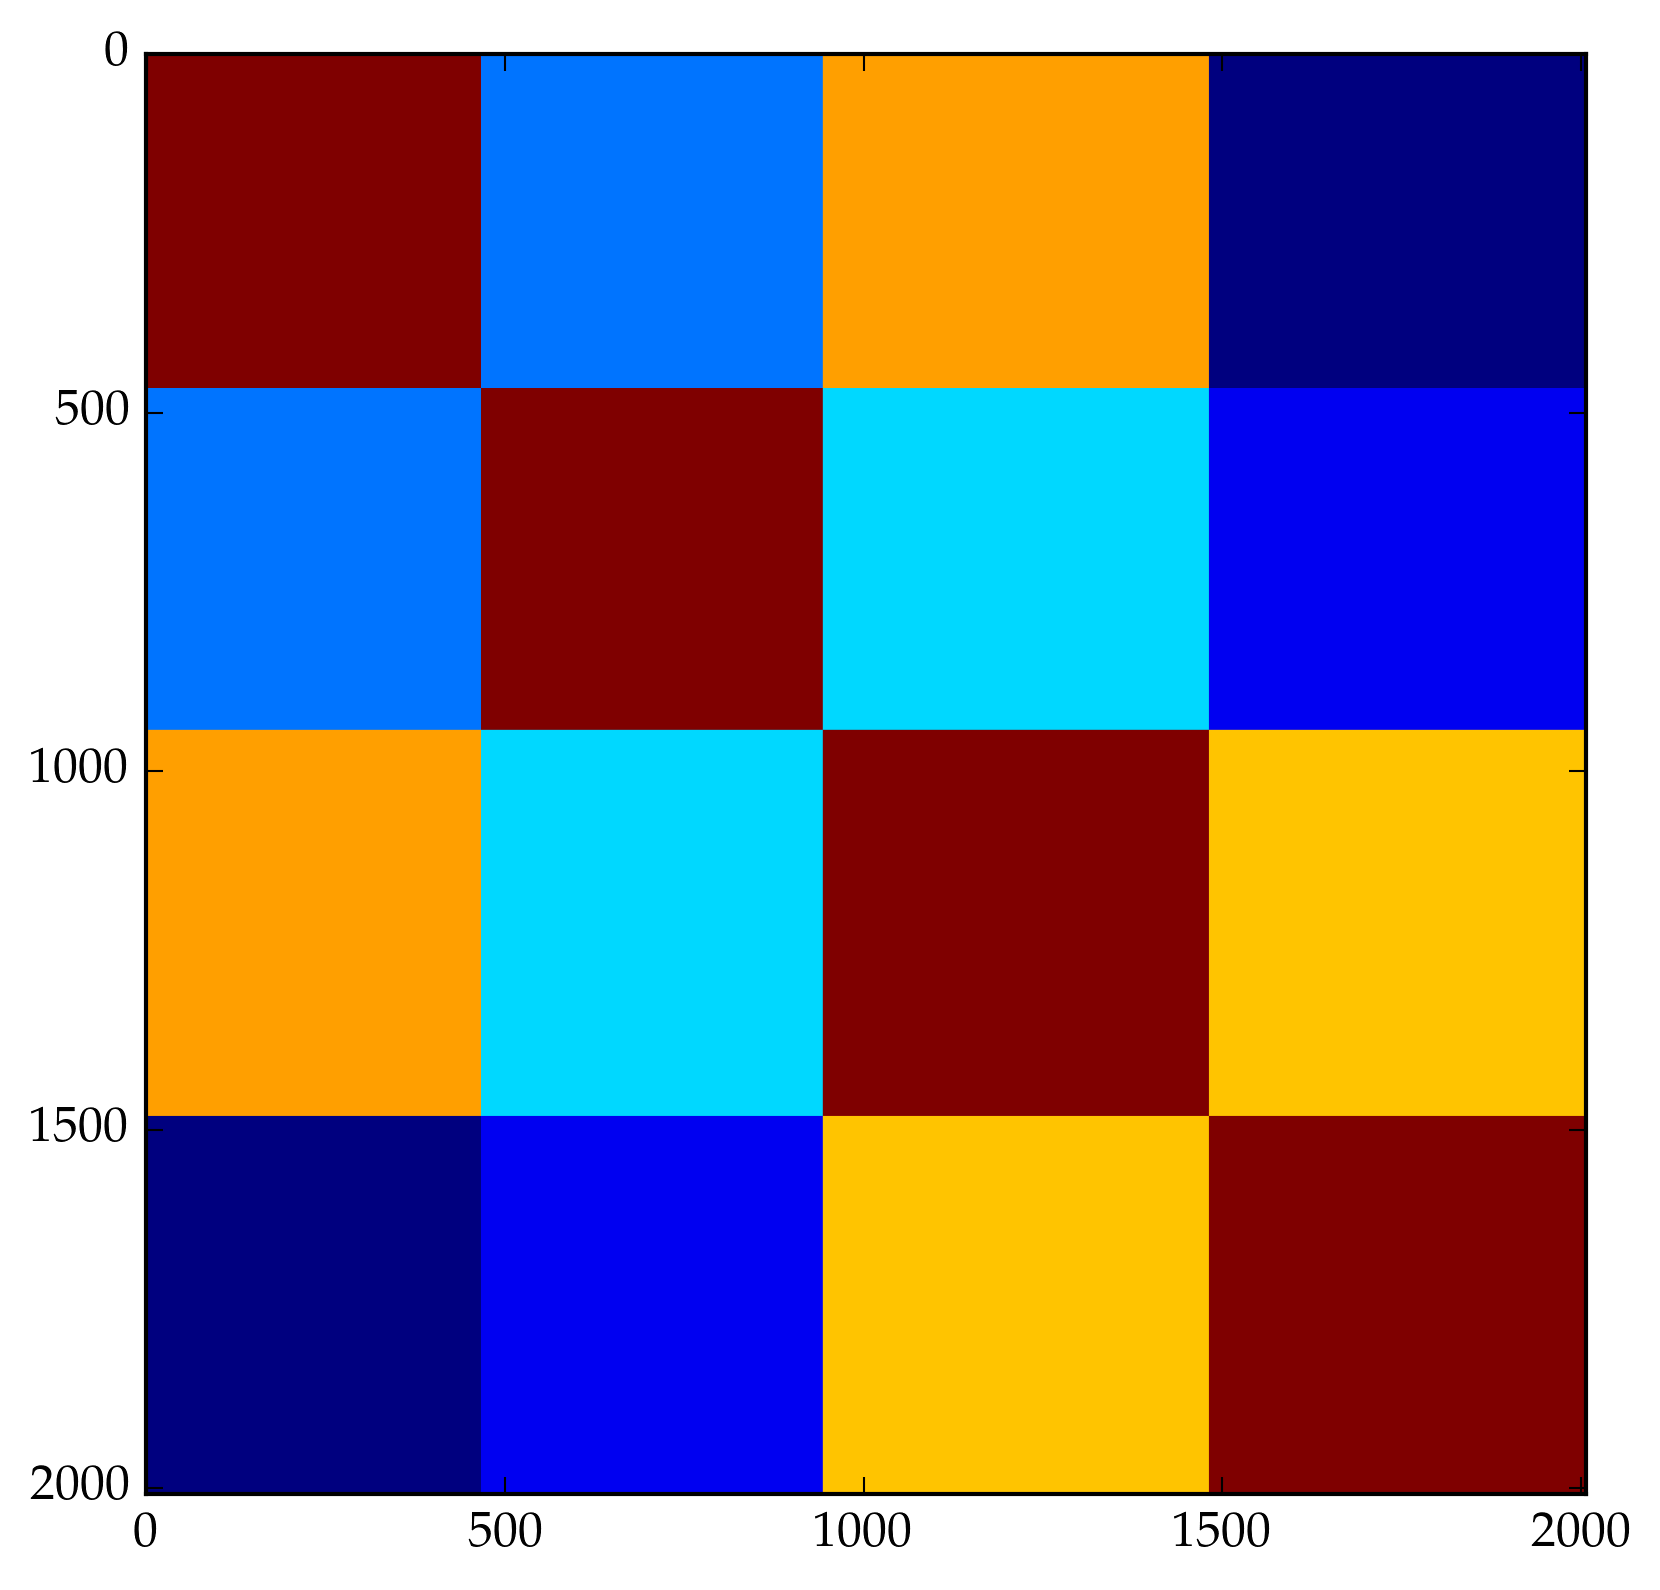

In [21]:
chunk_width=24*14
tstart=0.0
tend=tstart+chunk_width
in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
hourly_chunk = hourly_cat[in_chunk,:]
nobsv_chunk = sum(in_chunk)
station = convert(Vector{Int},hourly_chunk[:station])

cK_spatial = zeros(nobsv_chunk, nobsv_chunk)
for j in 1:nobsv_chunk
    for i in 1:j
        cK_spatial[i,j] = cK_stations[station[i], station[j]]
        cK_spatial[j,i] = cK_spatial[i,j]
    end
end
plt.imshow(cK_spatial)
;

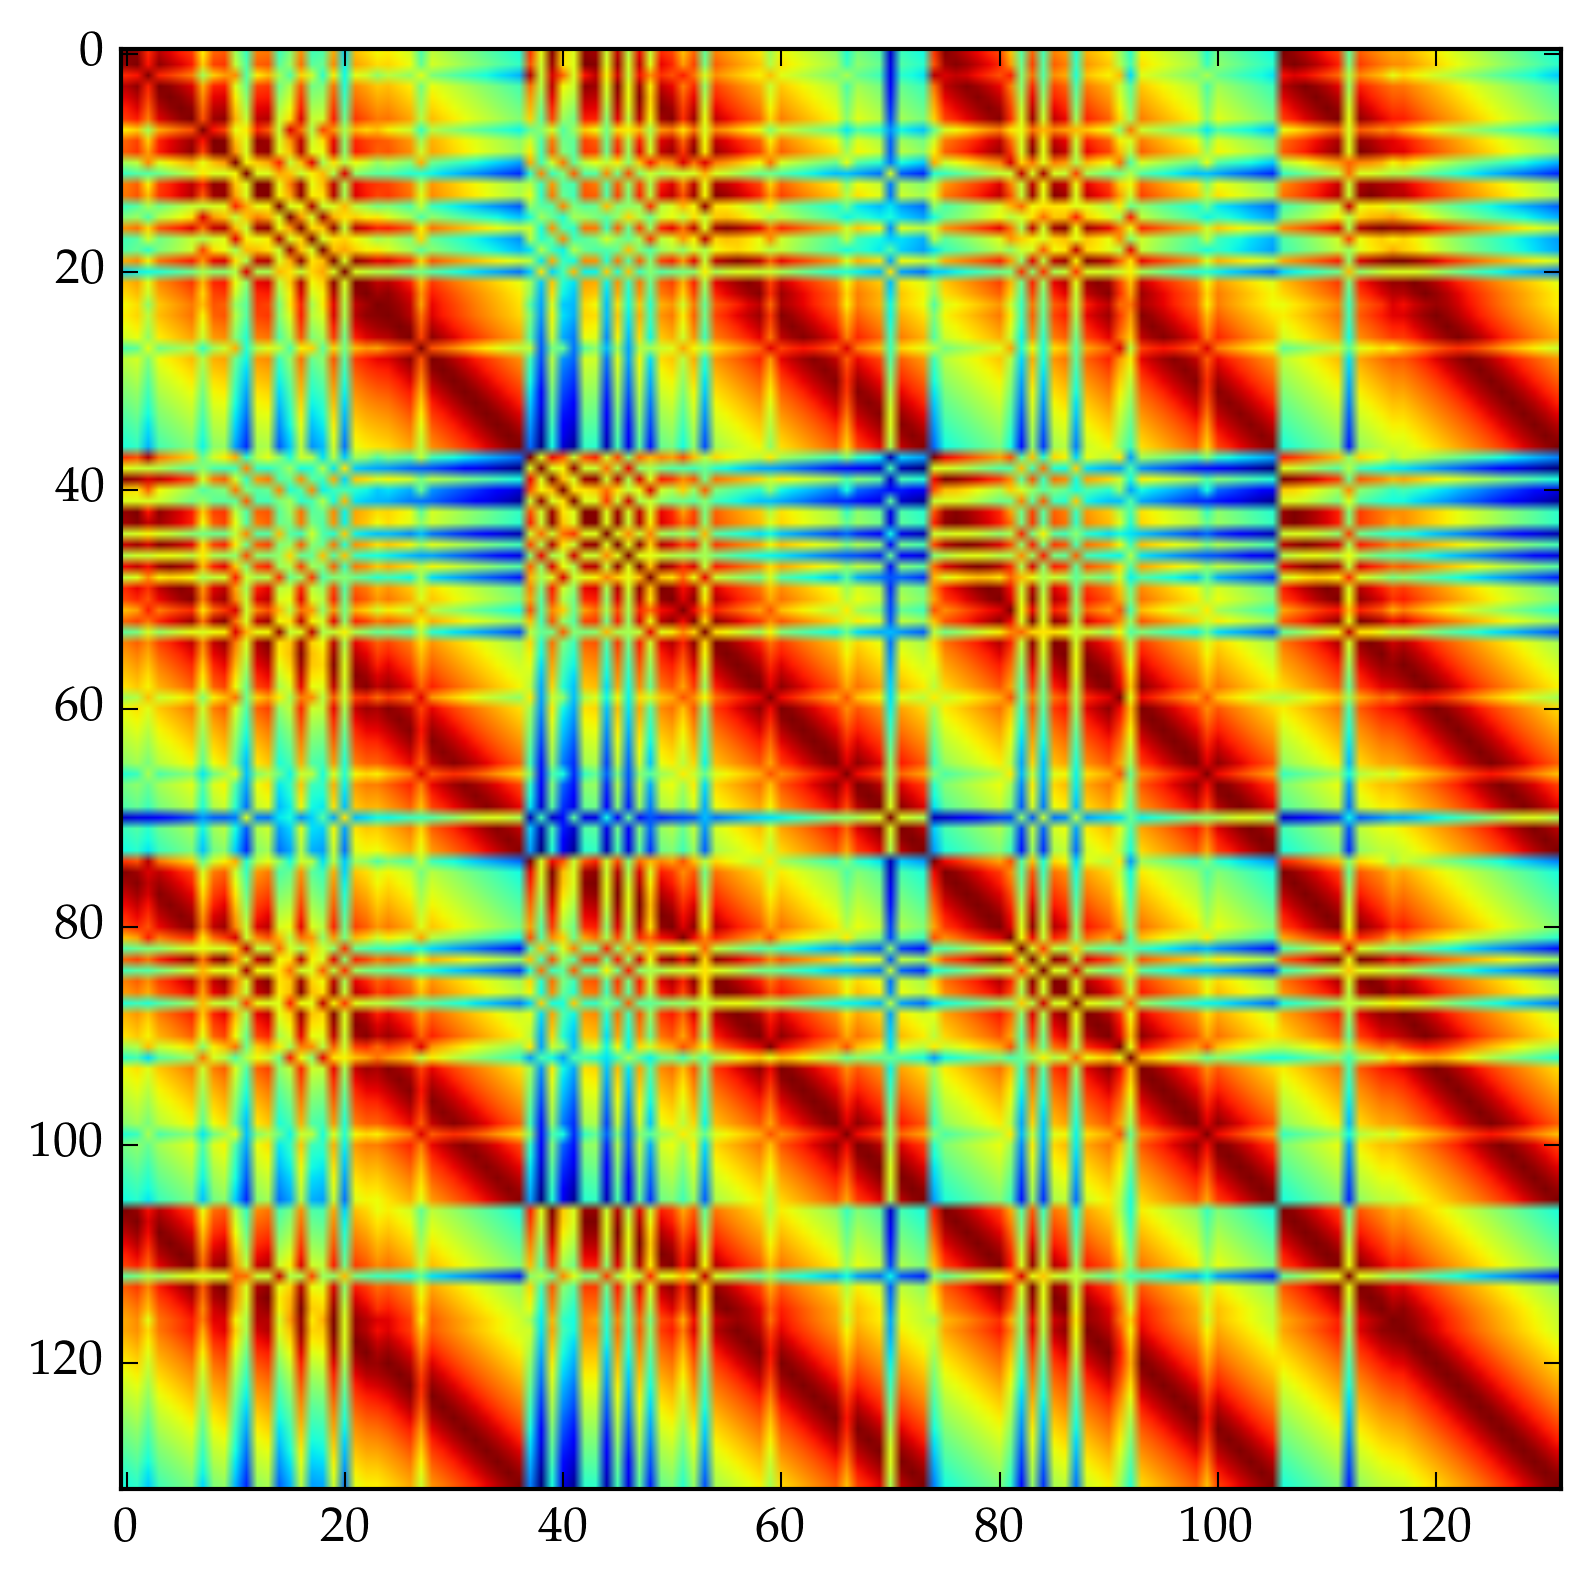

In [37]:
time = convert(Vector{Float64},hourly_chunk[:ts_hours])
temp = convert(Vector{Float64},hourly_chunk[:temp])
station = convert(Vector{Int},hourly_chunk[:station])
μ = mean(temp)
cK_temporal = cov(k_time, time')
plt.imshow(cK_temporal)
;

In [23]:
type Chunk
    time::Vector{Float64}
    station::Vector{Int}
    temp::Vector{Float64}
    μ::Float64
    cK_temporal::Matrix{Float64}
    cK::Matrix{Float64}
    nobsv::Int
end

In [24]:
type ChunkedSpatioTemporal
    chunks::Vector{Chunk}
    k_temporal::Kernel
    k_spatial::Kernel
    logNoise::Float64
    nobsv::Int
    nstations::Int
    pairwise::IsotropicData
    mLL::Float64
    dmLL::Vector{Float64}
end

In [25]:
chunks=Chunk[]
chunk_width=24*14
tstart=0.0
tend=tstart+chunk_width
nobsv=0
while tstart < get(maximum(hourly_cat[:ts_hours]))
    in_chunk=(tstart .<= hourly_cat[:ts_hours].values) & (hourly_cat[:ts_hours].values .< tend)
    hourly_chunk = hourly_cat[in_chunk,:]
    nobsv_chunk = sum(in_chunk)
    nobsv += nobsv_chunk
    
    time = convert(Vector{Float64},hourly_chunk[:ts_hours])
    temp = convert(Vector{Float64},hourly_chunk[:temp])
    station = convert(Vector{Int},hourly_chunk[:station])
    μ = mean(temp)
    cK_temporal = cov(k_time, time')
    cK_buffer = Array(Float64, nobsv_chunk, nobsv_chunk)
    chunk = Chunk(time, station, temp, μ, cK_temporal, cK_buffer, nobsv_chunk)
    push!(chunks, chunk)
    
    tstart=tend
    tend+=chunk_width
end

In [26]:
chunked_sptmp = ChunkedSpatioTemporal(chunks, k_time, k_spatial, hyp[1], 
    nobsv, nstations, 
    GaussianProcesses.IsotropicData(pairwiseD.^2),
    0.0,
    Float64[],
    )
;

# Using Masked kernels

In [52]:
chunk_X_PRJ = isdSubset[:X_PRJ].values[hourly_chunk[:station].values]
chunk_Y_PRJ = isdSubset[:Y_PRJ].values[hourly_chunk[:station].values]
chunk_X = [hourly_chunk[:ts_hours].values chunk_X_PRJ chunk_Y_PRJ]

132×3 Array{Float64,2}:
 8736.87  1.64799e6  1.0441e6 
 8737.87  1.64799e6  1.0441e6 
 8737.98  1.64799e6  1.0441e6 
 8738.87  1.64799e6  1.0441e6 
 8739.87  1.64799e6  1.0441e6 
 8740.87  1.64799e6  1.0441e6 
 8741.87  1.64799e6  1.0441e6 
 8742.72  1.64799e6  1.0441e6 
 8742.83  1.64799e6  1.0441e6 
 8742.87  1.64799e6  1.0441e6 
 8743.08  1.64799e6  1.0441e6 
 8743.42  1.64799e6  1.0441e6 
 8743.83  1.64799e6  1.0441e6 
    ⋮                         
 8748.88  1.51407e6  1.18374e6
 8749.88  1.51407e6  1.18374e6
 8750.88  1.51407e6  1.18374e6
 8751.88  1.51407e6  1.18374e6
 8752.88  1.51407e6  1.18374e6
 8753.88  1.51407e6  1.18374e6
 8754.88  1.51407e6  1.18374e6
 8755.88  1.51407e6  1.18374e6
 8756.88  1.51407e6  1.18374e6
 8757.88  1.51407e6  1.18374e6
 8758.88  1.51407e6  1.18374e6
 8759.88  1.51407e6  1.18374e6

In [56]:
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3])

Type: GaussianProcesses.ProdKernel
  Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
  Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [-3.21888,0.0]


In [58]:
GP(chunk_X', hourly_chunk[:temp].values, MeanConst(mean(hourly_chunk[:temp].values)), k_spatiotemporal, 0.0)

GP object:
  Dim = 3
  Number of observations = 132
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [-6.77803]
  Kernel:
    Type: GaussianProcesses.ProdKernel
      Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
      Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [-3.21888,0.0]
  Input observations = 
[8736.87 8737.87 … 8758.88 8759.88; 1.64799e6 1.64799e6 … 1.51407e6 1.51407e6; 1.0441e6 1.0441e6 … 1.18374e6 1.18374e6]
  Output observations = [-6.7,-5.6,-5.6,-5.0,-5.6,-5.0,-5.0,-5.0,-5.0,-5.0  …  -13.3,-12.8,-11.7,-11.1,-10.0,-9.4,-8.9,-8.9,-9.4,-10.0]
  Variance of observation noise = 1.0
  Marginal Log-Likelihood = -214.995

# Cached Kernel

In [29]:
type CachedKernel <: Kernel
    kern::Kernel
    cache::Dict{Tuple{VecF64, VecF64}, Float64}
    cache_grad::Dict{Tuple{VecF64,VecF64,Int}, Float64}
end

In [30]:
cov(ch::CachedKernel, x1::VecF64, x2::VecF64) = ch.cache[x1,x2]
get_params(ch::CachedKernel) = get_params(ch.kern)
num_params(ch::CachedKernel) = num_params(ch.kern)
get_param_names(ch::CachedKernel) = 
function set_params!(ch::CachedKernel)
    set_params!(ch.kern)
    ch.cache = Dict{Tuple{VecF64, VecF64}, Float64}()
    ch.cache_grad = Dict{Tuple{VecF64,VecF64,Int}, Float64}()
end

get_param_names (generic function with 1 method)

In [31]:
cache_spat = Dict{Tuple{VecF64, VecF64}, Float64}()
cache_grad_spat = Dict{Tuple{VecF64, VecF64, Int}, Float64}()
for i in 1:numstations
    for j in 1:numstations
        cache_spat[[float(i)],[float(j)]] = cK_spatial[i,j]
    end
end

In [33]:
ch = CachedKernel(cache_spat, cache_grad_spat)

LoadError: MethodError: no method matching CachedKernel(::Dict{Tuple{AbstractArray{Float64,1},AbstractArray{Float64,1}},Float64}, ::Dict{Tuple{AbstractArray{Float64,1},AbstractArray{Float64,1},Int64},Float64})[0m
Closest candidates are:
  CachedKernel(::Any, ::Any, [1m[31m::Any[0m) at In[29]:2
  CachedKernel{T}(::Any) at sysimg.jl:53[0m

In [34]:
X = vcat(time', station')
Y = temp
gp=GP(X, Y, MeanConst(mean(Y)), Masked(k_time, [1])*Masked(k_spatial, [2]))

GP object:
  Dim = 2
  Number of observations = 132
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [-6.77803]
  Kernel:
    Type: GaussianProcesses.ProdKernel
      Type: GaussianProcesses.Masked{GaussianProcesses.SumKernel}, Params: [-0.0806483,1.0449,1.50786,1.10795,-1.38548,-1.22736,-1.05138,3.09723,1.28737,2.84127,3.64666,0.469691,3.00962,7.70695,-5.39838]
      Type: GaussianProcesses.Masked{GaussianProcesses.SEIso}, Params: [-3.21888,0.0]
  Input observations = 
[8736.87 8737.87 … 8758.88 8759.88; 1.0 1.0 … 4.0 4.0]
  Output observations = [-6.7,-5.6,-5.6,-5.0,-5.6,-5.0,-5.0,-5.0,-5.0,-5.0  …  -13.3,-12.8,-11.7,-11.1,-10.0,-9.4,-8.9,-8.9,-9.4,-10.0]
  Variance of observation noise = 0.0
  Marginal Log-Likelihood = -191.915

In [35]:
cK_spatiotemp = cK_spatial .* cK_temporal
logNoise = hyp[1]
σy2 = exp(2.0*logNoise)
for i in 1:nobsv_chunk
    cK_spatiotemp[i,i] += σy2
end
plt.imshow(cK_spatiotemp)
;

LoadError: DimensionMismatch("arrays could not be broadcast to a common size")

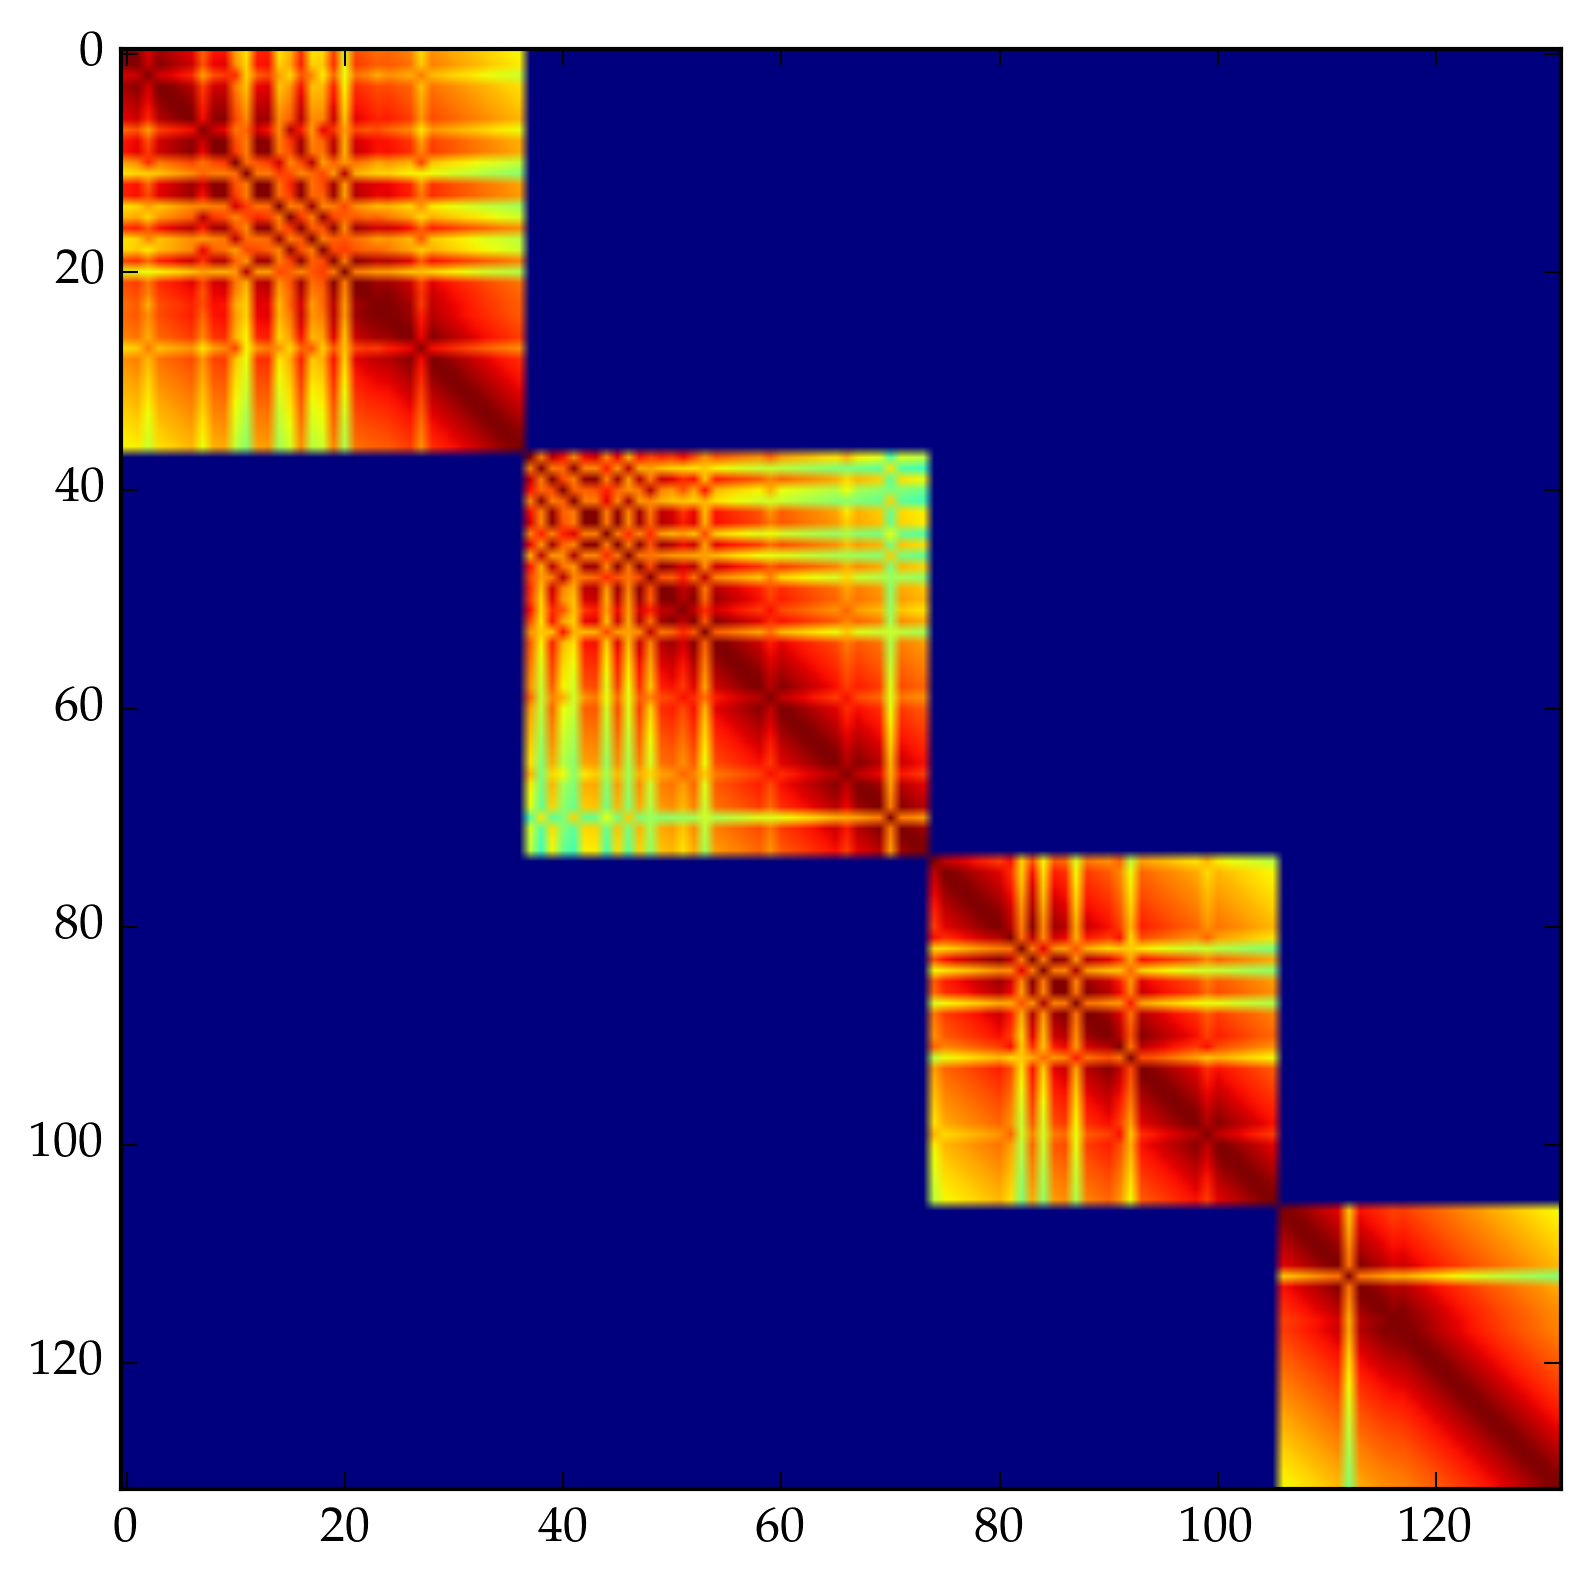

In [36]:
plt.imshow(gp.cK.mat)
;